---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [2]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [3]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline
from jejeqx._src.transforms.dataframe.spatial import Spherical2Cartesian
from jejeqx._src.transforms.dataframe.temporal import TimeDelta
from jejeqx._src.transforms.dataframe.scaling import MinMaxDF


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [4]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [5]:
# !cat configs/postprocess.yaml

In [6]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream.

In [49]:
%%time

# load config
config_dm = OmegaConf.load('./configs/postprocess.yaml')

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_FULL).compute()
ds_natl60

CPU times: user 11.6 s, sys: 2.24 s, total: 13.8 s
Wall time: 42.7 s


<xarray.Dataset>
Dimensions:  (time: 42, lat: 600, lon: 600)
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.6549 0.6571 0.6593 ... -0.2152 -0.2174
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

### Prediction Datasets 

In [50]:
%%time

experiment = "swot" # "nadir" #
if experiment == "nadir":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_nadir.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_NADIR.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()
elif experiment == "swot":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_swot.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_SWOT.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_SWOT.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_SWOT.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_SWOT.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_SWOT.data).compute()

CPU times: user 174 ms, sys: 36.1 ms, total: 210 ms
Wall time: 259 ms


In [51]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/

nadir1.nc  nadir4.nc  nadir5.nc  swot1nadir5.nc  swot.nc


In [52]:
nadir4_config = OmegaConf.load(f'./configs/natl60_obs.yaml')
ds_nadir4 = hydra.utils.instantiate(nadir4_config.ALONGTRACK_NADIR4.data).compute()
ds_swot1nadir5 = hydra.utils.instantiate(nadir4_config.ALONGTRACK_SWOT1NADIR5.data).compute()
ds_swot1nadir5

<xarray.Dataset>
Dimensions:  (time: 8778781)
Coordinates:
    lon      (time) float64 -57.81 -57.83 -57.85 -57.87 ... -58.29 -58.31 -58.33
    lat      (time) float64 42.96 42.9 42.84 42.78 ... 42.82 42.88 42.94 43.0
  * time     (time) datetime64[ns] 2012-10-01T00:45:50.676369 ... 2013-09-30T...
Data variables:
    ssh      (time) float64 -0.0028 -0.0097 -0.0153 ... 0.244 0.2186 0.1897
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

## Regrdding

In [53]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid, coord_based_to_grid


In [54]:
ds_nadir4 = coord_based_to_grid(
    coord_based_ds=ds_nadir4,
    target_grid_ds=ds_natl60.pint.dequantify(), 
)
ds_swot1nadir5 = coord_based_to_grid(
    coord_based_ds=ds_swot1nadir5,
    target_grid_ds=ds_natl60.pint.dequantify(), 
)

In [55]:
%%time

ds_duacs = grid_to_regular_grid(
    src_grid_ds=ds_duacs.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_miost = grid_to_regular_grid(
    src_grid_ds=ds_miost.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_siren = grid_to_regular_grid(
    src_grid_ds=ds_nerf_siren.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_ffn = grid_to_regular_grid(
    src_grid_ds=ds_nerf_ffn.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_mlp = grid_to_regular_grid(
    src_grid_ds=ds_nerf_mlp.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)

CPU times: user 49.5 s, sys: 938 ms, total: 50.5 s
Wall time: 50.7 s


### Preprocess Chain

In [56]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60 = hydra.utils.instantiate(psd_config.fill_nans)(ds_natl60.pint.dequantify())
ds_duacs = hydra.utils.instantiate(psd_config.fill_nans)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.fill_nans)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_mlp.pint.dequantify())


CPU times: user 19.2 s, sys: 84.8 ms, total: 19.3 s
Wall time: 19.4 s


In [57]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ssh"].attrs["units"] = "m"
    ds["ssh"].attrs["standard_name"] = "sea_surface_height"
    ds["ssh"].attrs["long_name"] = "Sea Surface Height"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

### SSH

In [58]:
from xmovie import Movie
from pathlib import Path

def custom_plot_ssh_obs(ds, fig, tt, *args, **kwargs):
    fig.set_size_inches(7, 5.5)
    ax = fig.add_subplot(111, )
    sub = ds.isel(time=tt)
    X, Y = np.meshgrid(ds.lon, ds.lat, indexing="ij")
    pts = ax.scatter(
        X, Y, c=np.ma.masked_invalid(sub).T, 
        marker="s",
        s=0.25,
        vmin=kwargs.pop("vmin", None), 
        vmax=kwargs.pop("vmax", None))
    ax.set(
        xlim=kwargs.pop("xlim", None),
        ylim=kwargs.pop("ylim", None),
    )
    plt.colorbar(pts, cmap="viridis")
    # sub.plot.scatter(x="lon", y="lat", ax=ax)
    # sub.plot.pcolormesh(ax=ax, cmap="viridis", **kwargs)
    # ax.set_aspect('equal')
    
    ax.set_title(pd.to_datetime(sub.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    return None, None

def custom_plot_ssh(ds, fig, tt, *args, **kwargs):
    fig.set_size_inches(7, 5.5)
    ax = fig.add_subplot(111, )
    sub = ds.isel(time=tt)
    sub.plot.pcolormesh(ax=ax, cmap="viridis", **kwargs,)
    sub.plot.contour(
        ax=ax, 
        levels=5, alpha=0.25, linewidths=1, cmap="black", **kwargs)
    # ax.set_aspect('equal')
    
    ax.set_title(pd.to_datetime(sub.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    return None, None

def create_movie(
    var, name, plotfunc=custom_plot_ssh, framedim: str = "steps", file_path=None, **kwargs
):

    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")    

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs,
        dpi=400, 
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.75,
        parallel=True,
    )

    return None

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


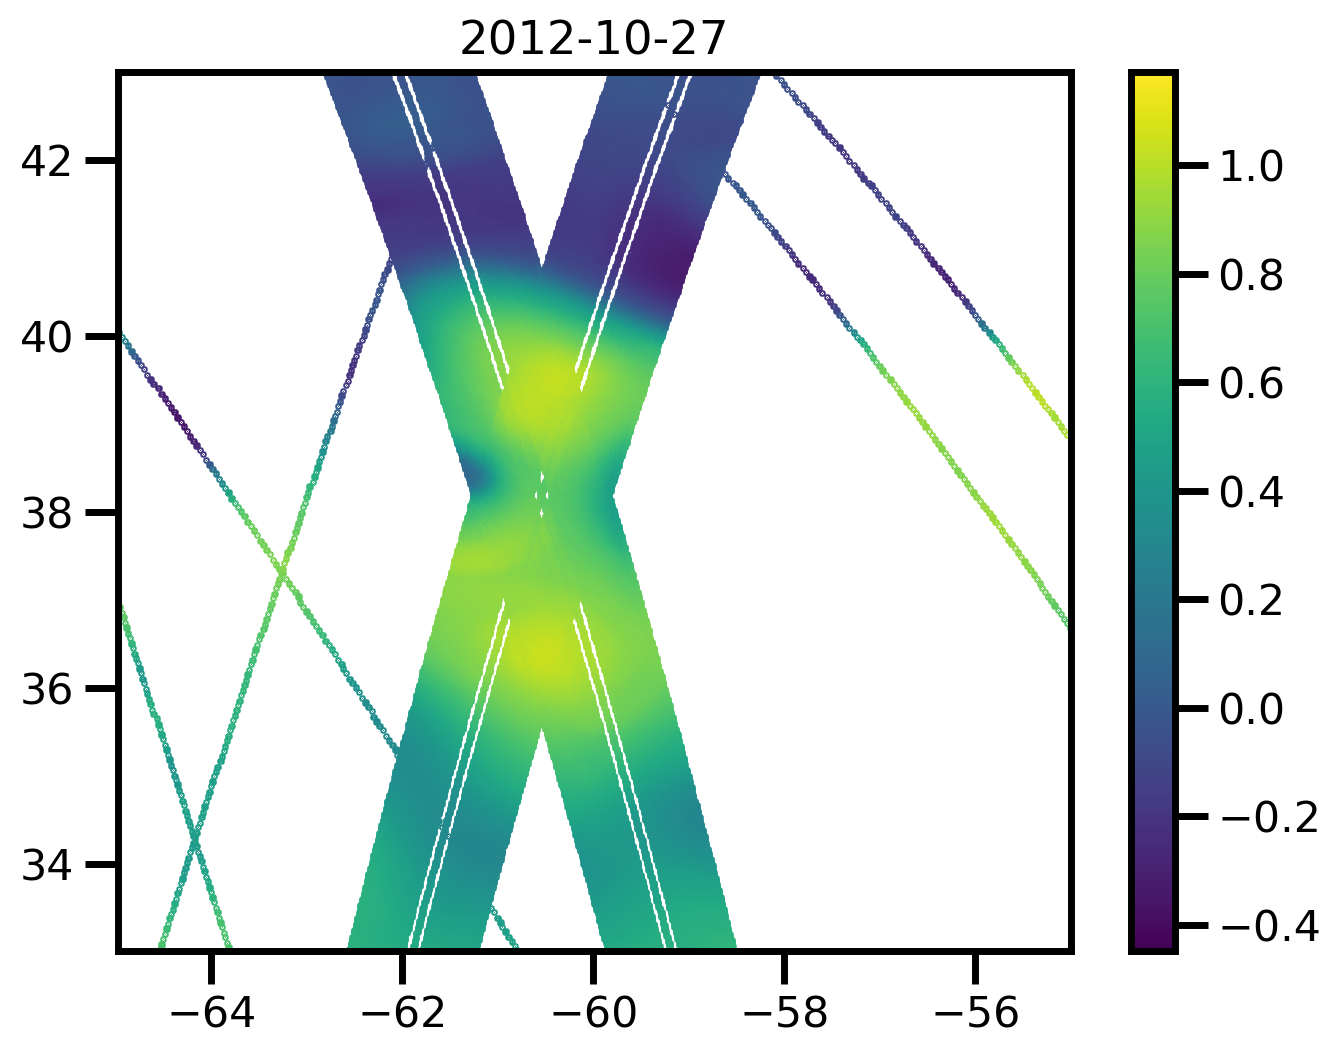

In [25]:
%matplotlib inline

vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]
mov = Movie(correct_labels(ds_swot1nadir5).ssh, plotfunc=custom_plot_ssh_obs, framedim="time", xlim=xlim, ylim=ylim)
mov.preview(5)

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(
/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2005: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)
/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2005: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)


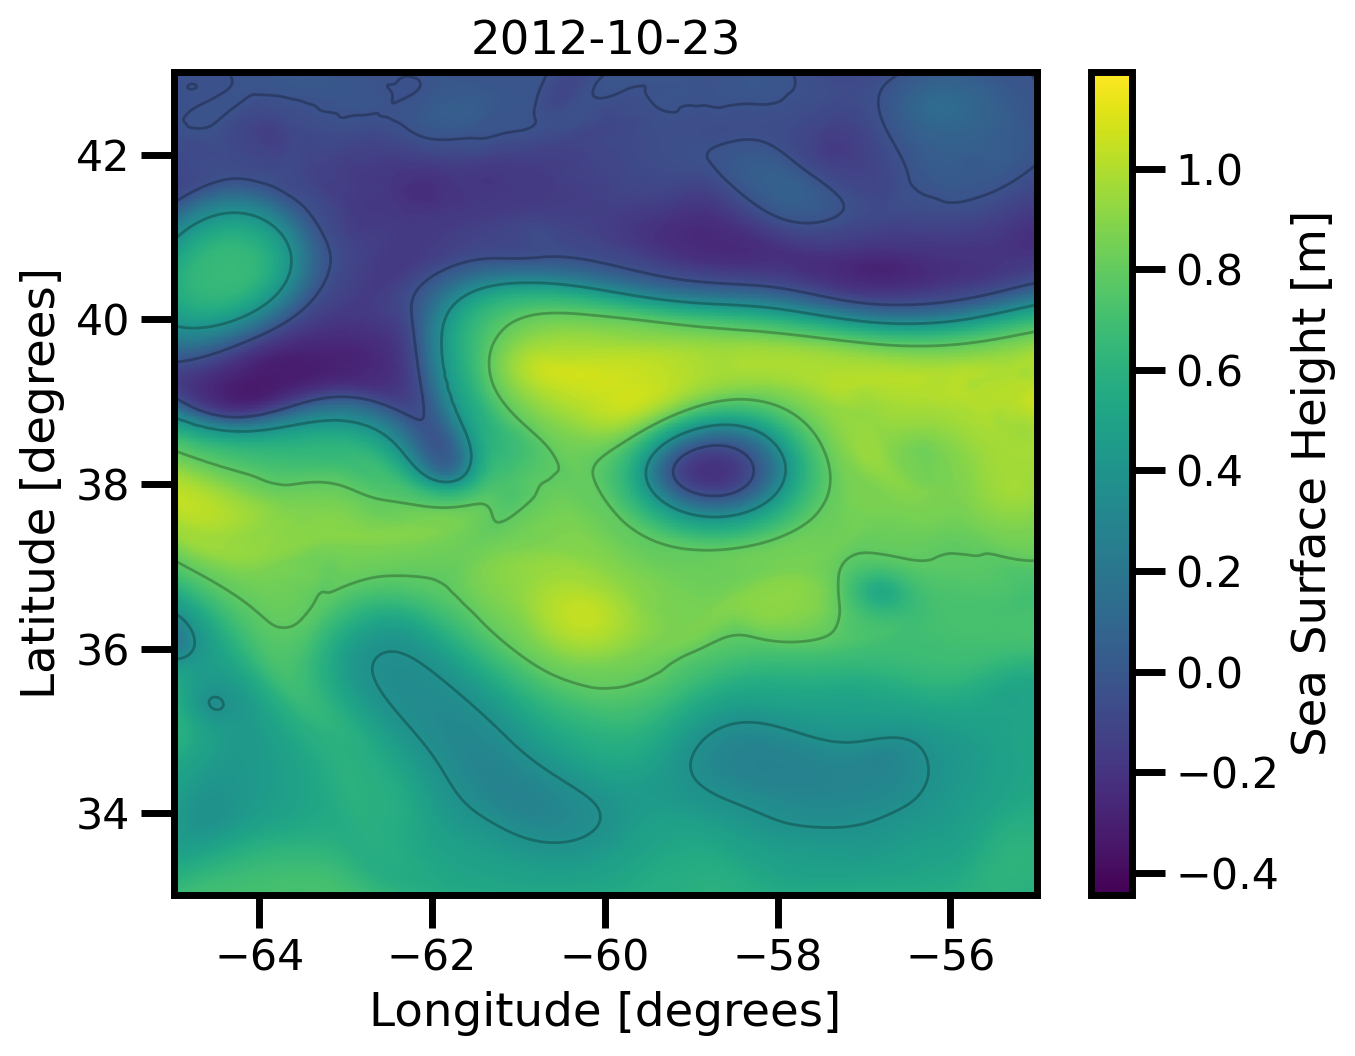

In [21]:
%matplotlib inline

vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()
mov = Movie(correct_labels(ds_natl60).ssh, plotfunc=custom_plot_ssh, framedim="time", rasterized=True)
mov.preview(1)

In [59]:
fig_path = "./figures/dc20a/movies"

In [60]:
correct_labels(ds_natl60).ssh.isel(time=slice(0,5)).chunk({'time':1})

<xarray.DataArray 'ssh' (time: 5, lat: 600, lon: 600)>
dask.array<xarray-<this-array>, shape=(5, 600, 600), dtype=float32, chunksize=(1, 600, 600), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -64.98 -64.97 -64.95 -64.93 ... -55.03 -55.02 -55.0
  * lat      (lat) float64 33.02 33.03 33.05 33.07 ... 42.95 42.97 42.98 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-10-26
Attributes:
    standard_name:       sea_surface_height
    long_name:           Sea Surface Height
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)
    actual_range:        [-0.7419584  1.1676793]
    units:               m

In [61]:
vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()

create_movie(
    correct_labels(ds_natl60).ssh.isel(time=slice(0,5)).chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name="dc20a_natl60_ssh",
    file_path=fig_path,
    framedim="time",
    # cbar_kwargs={"label": "Sea Surface Height ["},
    robust=True,
    vmin=vmin, vmax=vmax,
    rasterized=True
)

/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2005: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)
/gpfsscratch/rech/cli/uvo53rl/miniconda3/envs/jejeqx/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2005: UserWarning: The following kwargs were not used by contour: 'rasterized'
  primitive = ax.contour(x, y, z, **kwargs)


Movie created at movie_dc20a_natl60_ssh.mp4
GIF created at figures/dc20a/movies/movie_dc20a_natl60_ssh.gif


In [62]:
vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]

create_movie(
    correct_labels(ds_nadir4).ssh.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name="dc20a_nadir_ssh",
    plotfunc=custom_plot_ssh_obs,
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    robust=True,
    xlim=xlim, ylim=ylim
)

Movie created at movie_dc20a_nadir_ssh.mp4
GIF created at figures/dc20a/movies/movie_dc20a_nadir_ssh.gif


In [63]:
vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]

create_movie(
    correct_labels(ds_swot1nadir5).ssh.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name="dc20a_swot1nadir5_ssh",
    plotfunc=custom_plot_ssh_obs,
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    robust=True,
    xlim=xlim, ylim=ylim
)

Movie created at movie_dc20a_swot1nadir5_ssh.mp4
GIF created at figures/dc20a/movies/movie_dc20a_swot1nadir5_ssh.gif


In [64]:
vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()

create_movie(
    correct_labels(ds_natl60).ssh.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_natl60_ssh",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    robust=True,
)

Movie created at movie_dc20a_natl60_ssh_swot.mp4
GIF created at figures/dc20a/movies/movie_dc20a_natl60_ssh_swot.gif


In [65]:
vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()

# DUACS
create_movie(
    correct_labels(ds_duacs).ssh.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_duacs_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    robust=True,
)


Movie created at movie_dc20a_duacs_ssh_swot.mp4
GIF created at figures/dc20a/movies/movie_dc20a_duacs_ssh_swot.gif


In [66]:
vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()

# MIOST
create_movie(
    correct_labels(ds_miost).ssh.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_miost_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    # cbar_kwargs={"label": ""},
    robust=True,
)

Movie created at movie_dc20a_miost_ssh_swot.mp4
GIF created at figures/dc20a/movies/movie_dc20a_miost_ssh_swot.gif


In [67]:
vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()

# NerF - MLP
create_movie(
    correct_labels(ds_nerf_mlp).ssh.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_nerf_mlp_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    # cbar_kwargs={"label": ""},
    robust=True,
)

Movie created at movie_dc20a_nerf_mlp_ssh_swot.mp4
GIF created at figures/dc20a/movies/movie_dc20a_nerf_mlp_ssh_swot.gif


In [68]:
vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()

# NerF - FFN
create_movie(
    correct_labels(ds_nerf_ffn).ssh.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_nerf_ffn_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    # cbar_kwargs={"label": ""},
    robust=True,
)

Movie created at movie_dc20a_nerf_ffn_ssh_swot.mp4
GIF created at figures/dc20a/movies/movie_dc20a_nerf_ffn_ssh_swot.gif


In [69]:
vmin, vmax = correct_labels(ds_natl60).ssh.min(), correct_labels(ds_natl60).ssh.max()


# NerF - FFN
create_movie(
    correct_labels(ds_nerf_siren).ssh.chunk({'time':1}), #.sel(time=slice("2017-02-01", "2017-03-01")),
    name=f"dc20a_nerf_siren_ssh_{experiment}",
    file_path=fig_path,
    framedim="time",
    vmin=vmin, vmax=vmax,
    # cbar_kwargs={"label": ""},
    robust=True,
)

Movie created at movie_dc20a_nerf_siren_ssh_swot.mp4
GIF created at figures/dc20a/movies/movie_dc20a_nerf_siren_ssh_swot.gif
